# Neural Networks

This notebook shows examples of operation of the custom-written library.

In [102]:
import numpy as np
import matplotlib.pyplot as plt

from neurnet import NeuralNetwork

## Example 1: one-to-one fit of numerical data

This example shows how to train the neural network to fit a simple function of the form $f(x) = 2x^2$. The training relies on noisy data. After training, $x$ values are forwardpropagated to obtain the predictions.

A total of 64 $\times$ ReLU units are used on each hidden layers. The output layer contains a single neuron with linear activation function.

In [17]:
# Generate synthetic data with noise
def scalar_function(X):
    return 2*X**2

n_vals = 100
noise = 10
X_test = np.linspace(-10,10, n_vals).reshape(1, n_vals)
Y_test = scalar_function(X_test) + noise*np.random.randn(1, n_vals)

In [27]:
# Create the network
topology = [4, 4, 1]
activation_funcs = ['relu',
                    'relu',
                    'linear']
n_inputs = 1
ryc = NeuralNetwork(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

cost = ryc.train(X_test, Y_test,
                 num_epochs=5000,
                 batch_size=50,
                 learning_rate=1e-5,
                 verbose=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:05<00:00, 864.86it/s] 


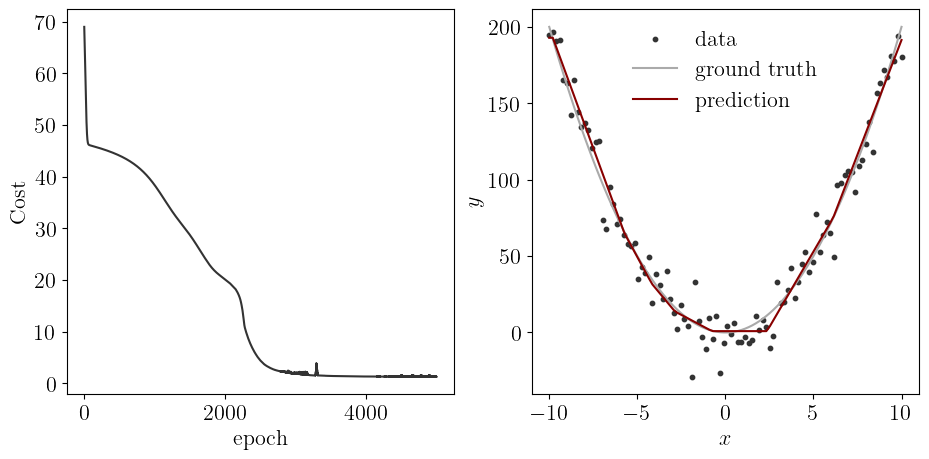

In [28]:
# Plots 
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig, axs = plt.subplots(ncols=2, figsize=(11, 5))
ax_cost = axs[0]
ax_result = axs[1]

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")


ax_result.scatter(X_test.T,
               Y_test.T,
               s=10,
               color="#333333",
               label="data")


ax_result.plot(X_test.T,
               scalar_function(X_test.T),
                color="#aaaaaa",
                label="ground truth")


ax_result.plot(X_test.T,
               ryc.forward(X_test).T,
                color="#880000",
                label="prediction")

ax_result.legend(frameon=False)

ax_result.set_xlabel(r"$x$")
ax_result.set_ylabel(r"$y$")

plt.show()


## Example 2: many-to-one fit of numerical data

Herein is described training of a neural network to fit a function of the form $z(x,y) = 2x^2+ 3y^2$, which defines a paraboloid. The training relies on noisy data. After training, pairs of $x,y$ values are forward-propagated to obtain predictions for $z$.

We use 3 hidden layers, where the first two use sigmoids as activation functions. The last layer is a single neuron with linear activation function.

In [31]:
# Generate synthetic data with noise
def scalar_function_two_variables(X,Y):
    return 2*X**2 + 3*Y**2

n_vals = 20
noise = 10
X_test = np.linspace(-10,10, n_vals)
Y_test = np.linspace(-10,10, n_vals)

X_test_grid, Y_test_grid = np.meshgrid(X_test,Y_test)
X_test_grid_flat = X_test_grid.reshape(1, n_vals*n_vals)
Y_test_grid_flat = Y_test_grid.reshape(1, n_vals*n_vals)
XY_test_grid_flat = np.vstack( (X_test_grid_flat.reshape(1, n_vals*n_vals), Y_test_grid_flat.reshape(1, n_vals*n_vals)) )

Z_test = scalar_function_two_variables(X_test_grid_flat, Y_test_grid_flat) + noise*np.random.randn(1, n_vals*n_vals)

In [36]:
# Create the network
topology = [8, 8, 1]
activation_funcs = ['sigmoid',
                    'sigmoid',
                    'linear']
n_inputs = 2
ryc = NeuralNetwork(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

# Training
cost = ryc.train(XY_test_grid_flat,
                 Z_test,
                 num_epochs=1000,
                 batch_size=20,
                 learning_rate=1e-5,
                 verbose=False)

100%|██████████| 1000/1000 [00:13<00:00, 76.35it/s]


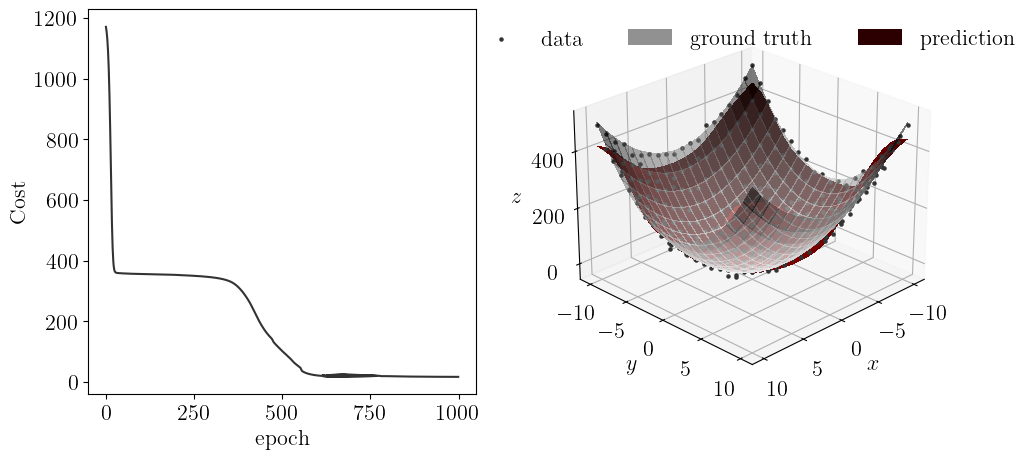

In [37]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig = plt.figure( figsize=(11, 5) )

# Panel cost
ax_cost = fig.add_subplot(1, 2, 1)
ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")


# Panel 3d fit
ax_result = fig.add_subplot(1, 2, 2, projection='3d')

ax_result.scatter(X_test_grid_flat.T,
                  Y_test_grid_flat.T,
                  Z_test,
                  s=5,
                  color="#333333",
                  depthshade=0,
                  label="data")

surf = ax_result.plot_surface(X_test_grid,
                              Y_test_grid,
                              scalar_function_two_variables(X_test_grid,Y_test_grid),
                              cmap=cm.Greys,
                              alpha=0.5,
                              linewidth=0,
                              antialiased=False,
                              label="ground truth")

ax_result.plot_surface(X_test_grid,
                        Y_test_grid,
                        ryc.forward(XY_test_grid_flat).reshape(n_vals, n_vals),
                        color="#880000",
                        linewidth=0,
                        antialiased=False,
                        label="prediction")

ax_result.view_init(elev=25,
                    azim=45)

ax_result.legend(loc="upper center",
                 ncol=3,
                 frameon=False)

ax_result.set_xlabel(r"$x$")
ax_result.set_ylabel(r"$y$")
ax_result.set_zlabel(r"$z$")

plt.show()


## Example 3: Many-to-many, fitting a vectorial field

We will use the neural network to find an approximate solution to a vectorial field of the form $\mathbb{R}^2 \rightarrow \mathbb{R}^2$. We consider the vectorial field $\mathbf{r}(x,y) = R \sin(-\theta)\mathbf{\hat{i}} + R\cos(\theta) \mathbf{\hat{i}}$, where $\theta \equiv \mathrm{atan}(y/x)$ and $R\equiv \sqrt{x^2 + y^2}$. To make the problem more realistic, the values for the training vectors incoporate random Gaussian noise $\mathbf{r}_\mathrm{train} = \mathbf{r} + R\xi$ 

In [40]:
# Created the data and prepare it for the traiing 
def vector_field(x, y, noise):

    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y, x)
    theta = np.where(theta<0, 2*np.pi + theta, theta)

    x_comp = r*np.sin(-theta) + r*noise*np.random.randn(x.shape[0], x.shape[1])
    y_comp = r*np.cos(theta) + r*noise*np.random.randn(x.shape[0], x.shape[1])


    return x_comp, y_comp

n_vals = 20
noise = 0.20
X_test = np.linspace(-5, 5, n_vals)
Y_test = np.linspace(-5, 5, n_vals)

X_test = X_test.reshape(1,n_vals)
Y_test = Y_test.reshape(1,n_vals)

X_test_grid, Y_test_grid = np.meshgrid(X_test, Y_test)
X_test_grid_flat = X_test_grid.reshape(1, n_vals*n_vals)
Y_test_grid_flat = Y_test_grid.reshape(1, n_vals*n_vals)
XY_test = np.vstack((X_test_grid_flat, Y_test_grid_flat))

u, v =  vector_field(X_test_grid_flat, Y_test_grid_flat, noise)
UV_test = np.vstack((u,v))

In [48]:
# Create the network
n_inputs = 2
topology = [8, 8, 2]
activation_funcs = ['relu',
                    'relu',
                    'linear']

ryc = NeuralNetwork(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

cost = ryc.train(XY_test,
                 UV_test,
                 num_epochs = 25000,
                 batch_size = 100,
                 learning_rate = 5e-4,
                 verbose=False)

UV_pred = ryc.forward(XY_test)


100%|██████████| 25000/25000 [00:57<00:00, 436.36it/s]


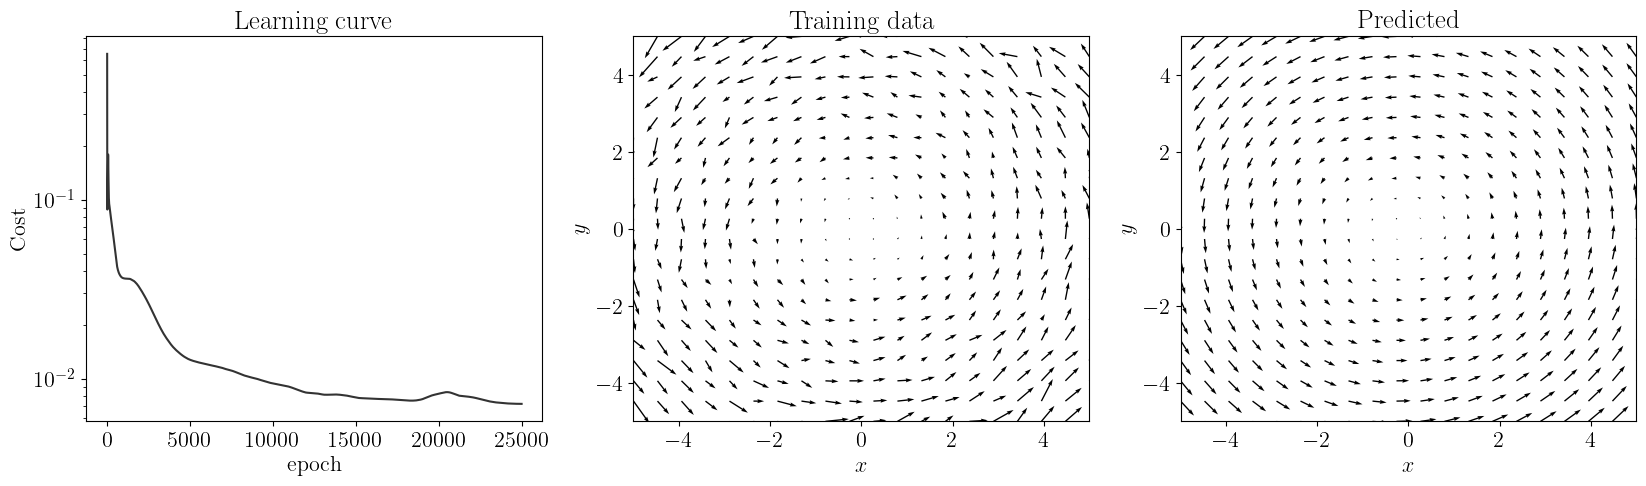

In [49]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(20, 5) )

#---

ax_cost = fig.add_subplot(1, 3, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')
ax_cost.set_title("Learning curve")

#---

ax_input = fig.add_subplot(1, 3, 2)
ax_input.quiver(X_test_grid_flat, Y_test_grid_flat, u, v)

ax_input.set_ylabel(r"$y$")
ax_input.set_xlabel(r"$x$")
ax_input.set_ylim([-5, 5])
ax_input.set_xlim([-5, 5])
ax_input.set_title("Training data")

#---
ax_predicted = fig.add_subplot(1, 3, 3)
ax_predicted.quiver(X_test_grid_flat, Y_test_grid_flat,
                    UV_pred[0,:], UV_pred[1,:])

ax_predicted.set_ylabel(r"$y$")
ax_predicted.set_xlabel(r"$x$")
ax_predicted.set_ylim([-5, 5])
ax_predicted.set_xlim([-5, 5])
ax_predicted.set_title("Predicted")

plt.show()

## Example 4: Binary classification

In this example is described how to binary classify data. Using polar coordinates $r = r(\theta)$ we consider two partially overlapping distributions, $r_1 \sim \mathcal{N}(R_1, \sigma_1)$ and $r_2 \sim \mathcal{N}(R_2, \sigma_2)$. These two  populations define concentric circles and each of them is labeled with either $y=1$ or $y=0$. Note that the label is independent of the $\theta$ argument. The task of the neural network is to classify the two populations, learning the irrelevance of $\theta$ to describe the data class. That is, we will obtain conditional probabilities $p(y=1 | r,\theta) \simeq p(y=1 | r) $.

In [51]:
# Generate data in polar coordinates with significant noise
n_vals = 100
noise = 0.3
theta_test = np.linspace(0, 2*np.pi, n_vals).reshape(1, n_vals)
R_test1 = noise*np.random.randn(1, n_vals) + 1
R_test2 = noise*np.random.randn(1, n_vals) + 2

thetas = np.hstack( (theta_test,theta_test) )
Rs = np.hstack( (R_test1, R_test2) )
X = np.vstack((thetas, Rs))
labels = np.hstack( (np.zeros(n_vals), np.ones(n_vals)) ).reshape(1, 2*n_vals)

In [110]:
# Create the network and training
topology = [2,1]
activation_funcs = ['relu',
                    'sigmoid']
n_inputs = 2
ryc = NeuralNetwork(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='bin-cross-entropy')

cost = ryc.train(X,
                 labels,
                 num_epochs=16_000,
                 batch_size=50,
                 learning_rate=5e-6,
                 verbose=False)


pred_labels = ryc.forward(X).reshape(2*n_vals, 1)
#pred_labels = np.where(pred_labels > 0.5, 1, 0) # We could make a hard threshold to attribute a class to the probabilities

  1%|          | 94/16000 [00:00<00:44, 357.65it/s]

100%|██████████| 16000/16000 [00:36<00:00, 443.20it/s]


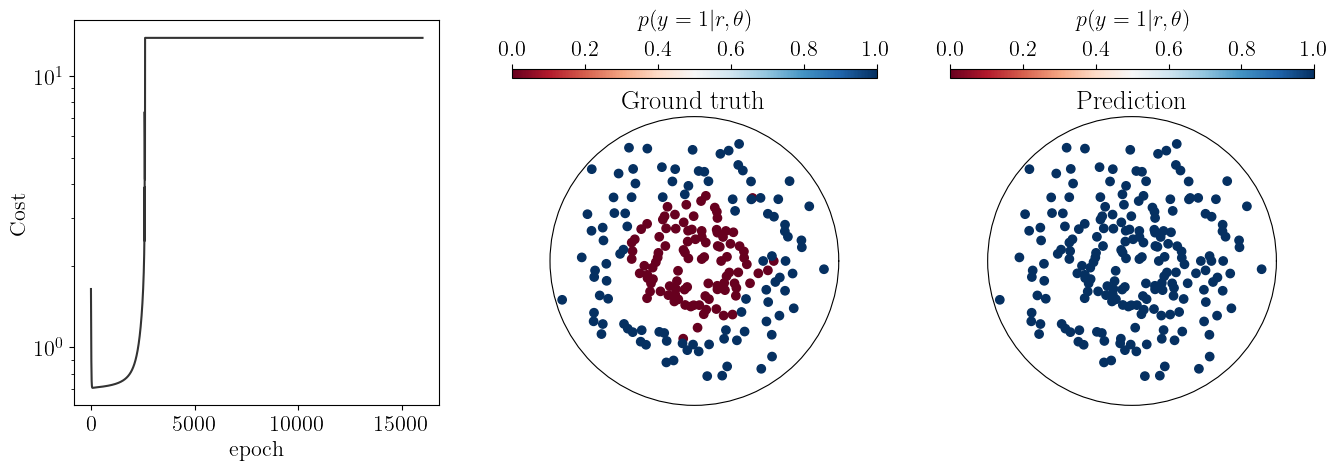

In [111]:
# Plot
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(16, 5) )

#---

ax_cost = fig.add_subplot(1, 3, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')

#---

ax_referece = fig.add_subplot(1, 3, 2, projection='polar')

ax_referece.set_xticks([])
ax_referece.set_yticks([])
ax_referece.set_title("Ground truth")

labels_reference_plot = ax_referece.scatter(thetas,
                                            Rs,
                                            c = labels,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_ref = plt.colorbar(labels_reference_plot,
                        ax=ax_referece,
                        orientation='horizontal',
                        location='top',
                        pad=0.1,
                        aspect=40)

cbar_ref.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---

ax_result = fig.add_subplot(1, 3, 3, projection='polar')

ax_result.set_xticks([])
ax_result.set_yticks([])
ax_result.set_title("Prediction")

labels_predicted_plot = ax_result.scatter(thetas,
                                            Rs,
                                            c = pred_labels,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_res = plt.colorbar(labels_predicted_plot,
                    ax=ax_result,
                    orientation='horizontal',
                    location='top',
                    pad=0.1,
                    aspect=40)

cbar_res.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---

plt.show()